In [43]:
import hgfp
import torch
import dgl
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt

import tempfile
import os
import shutil


from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from openeye import oechem
from openforcefield.topology import Molecule
from openforcefield.topology import Topology
from openforcefield.typing.engines.smirnoff import ForceField
FF = ForceField('test_forcefields/smirnoff99Frosst.offxml')



In [52]:
import xml.etree.ElementTree as ET
tree = ET.parse('/Users/wangy1/anaconda3/envs/hgfp/lib/python3.7/site-packages/openmmforcefields/ffxml/amber/gaff/ffxml/gaff-1.81.xml')
root = tree.getroot()
nb = root.getchildren()[-1]
atom_types = [atom.get('type') for atom in nb.findall('Atom')]

atom_types.remove('cd')
atom_types.remove('cf')
atom_types.remove('cq')
atom_types.remove('pd')
atom_types.remove('pf')
atom_types.remove('nd')

str_2_idx = dict(zip(atom_types, range(len(atom_types))))
idx_2_str = dict(zip(range(len(atom_types)), atom_types))

str_2_idx['cd'] = str_2_idx['cc']
str_2_idx['cf'] = str_2_idx['ce']
str_2_idx['cq'] = str_2_idx['cp']
str_2_idx['pd'] = str_2_idx['pc']
str_2_idx['pf'] = str_2_idx['pe']
str_2_idx['nd'] = str_2_idx['nc']

print(idx_2_str)

{0: 'c', 1: 'c1', 2: 'c2', 3: 'c3', 4: 'ca', 5: 'cp', 6: 'cc', 7: 'ce', 8: 'cg', 9: 'ch', 10: 'cx', 11: 'cy', 12: 'cu', 13: 'cv', 14: 'cz', 15: 'h1', 16: 'h2', 17: 'h3', 18: 'h4', 19: 'h5', 20: 'ha', 21: 'hc', 22: 'hn', 23: 'ho', 24: 'hp', 25: 'hs', 26: 'hw', 27: 'hx', 28: 'f', 29: 'cl', 30: 'br', 31: 'i', 32: 'n', 33: 'n1', 34: 'n2', 35: 'n3', 36: 'n4', 37: 'na', 38: 'nb', 39: 'nc', 40: 'ne', 41: 'nf', 42: 'nh', 43: 'no', 44: 'ni', 45: 'nj', 46: 'nk', 47: 'nl', 48: 'nm', 49: 'nn', 50: 'np', 51: 'nq', 52: 'o', 53: 'oh', 54: 'os', 55: 'op', 56: 'oq', 57: 'ow', 58: 'p2', 59: 'p3', 60: 'p4', 61: 'p5', 62: 'pb', 63: 'pc', 64: 'pe', 65: 'px', 66: 'py', 67: 's', 68: 's2', 69: 's4', 70: 's6', 71: 'sh', 72: 'ss', 73: 'sp', 74: 'sq', 75: 'sx', 76: 'sy'}


/Users/wangy1/anaconda3/envs/hgfp/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  after removing the cwd from sys.path.


In [53]:
gs = []

from openeye import oechem
ifs = oechem.oemolistream()
ifs.open('/Users/wangy1/Documents/hgfp_scripts/gcn_param/parm_at_Frosst/zinc.sdf')

idx = 0
for molecule in ifs.GetOEMols():
    if idx > 100:
        break
    try:
        g = hgfp.graph.from_oemol(molecule)
        g = hgfp.heterograph.from_graph(g)

        molecule = Molecule.from_openeye(molecule)
        print(molecule.to_smiles())
        from openmmforcefields.generators import GAFFTemplateGenerator
        gaff = GAFFTemplateGenerator(molecules=molecule, forcefield='gaff-1.81')

        # Create temporary directory for running antechamber

        tmpdir = tempfile.mkdtemp()
        prefix = 'molecule'
        input_sdf_filename = os.path.join(tmpdir, prefix + '.sdf')
        gaff_mol2_filename = os.path.join(tmpdir, prefix + '.gaff.mol2')
        frcmod_filename = os.path.join(tmpdir, prefix + '.frcmod')

        # Write MDL SDF file for input into antechamber
        molecule.to_file(input_sdf_filename, file_format='sdf')

        gaff._run_antechamber(molecule_filename=input_sdf_filename, input_format='mdl',
                gaff_mol2_filename=gaff_mol2_filename, frcmod_filename=frcmod_filename)
        gaff._read_gaff_atom_types_from_mol2(gaff_mol2_filename, molecule)
        gaff_types = [atom.gaff_type for atom in molecule.atoms]
        shutil.rmtree(tmpdir)

        g.nodes['atom'].data['type'] = torch.tensor(
            [str_2_idx[type_str] for type_str in gaff_types])

        gs.append(g)
        idx += 1
    except:
        pass
    

[H]/C(=C(/[H])\C([H])([H])C([H])([H])C(=O)C([H])([H])C([H])([H])[H])/C#CC#CC#CC([H])([H])[H]
[H]c1c(c(c(c(c1[H])[H])[C@@]2([N@](C(C(O2)([H])[H])([H])[H])C([H])([H])[H])[H])[H])[H]
[H]c1c(c(c(c(c1[H])[H])C(=O)N2C(C(=C(C([S@]2=O)([H])[H])C([H])([H])[H])C([H])([H])[H])([H])[H])[H])[H]
[H]C1(C2=C(C(C1([H])[H])([H])[H])SSC2=O)[H]
[H]C1=C(C2=C(N1[H])C(C(C(C2([H])[H])([H])[H])([H])[H])([H])[H])C3=NC4=NN=C(N4[N-]3)[H]
[H]C1=C(C(=C(S1)Cl)OC([H])([H])[H])N([H])C(=O)N(C([H])([H])[H])C([H])([H])[H]
[H]c1c(c(c2c(c1[H])C(=O)[C@@]3([C@]2(Oc4c3c(c(c(c4[H])[H])C([H])([H])[H])[H])O[H])O[H])[H])[H]
[H]c1c(c(c\2c(c1[H])C(=C(O/C2=[N+](\[H])/C(=O)C([H])([H])[H])C([H])([H])[H])C#N)[H])[H]
[H]c1c(c(c(c(c1[H])[H])C2=NSC(=N2)S(=O)(=O)N([H])[C@]([H])(c3c(c(c(c(n3)[H])[H])[H])[H])C([H])([H])[H])[H])[H]
[H]c1c(c(c(c(c1[H])[H])C2=C3N=NC4=C(SC(=C4N3N=C2C([H])([H])[H])[H])N([H])C(=O)C([H])([H])[H])[H])[H]
[H]c1c(c2=C3[C@](C(=O)C(C(O3)(C([H])([H])[H])C([H])([H])[H])([H])[H])([N+](=c2c(c1[H])C([H])([H])[H])[H])[H])[H]


[H]c1c(c(c2c(c1[H])N=C(N=C(N2[H])c3c(c(nc(c3[H])[H])[H])[H])c4c(c(c(c(c4[H])[H])C([H])([H])[H])[H])[H])[H])[H]
[H]C1=C(OC(=C1[H])/C(=C(\[H])/c2c(c(c(c(n2)OC([H])([H])[H])C#N)C#N)C([H])([H])[H])/[H])[H]
[H][C@@]1(C(=C(N2C1=NC3=C2C(=O)N(C(=O)N3C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])OC([H])([H])[H]
[H][C@@]1(C(=O)N2[C@]1(C(C(OC23C(C(C(C(C3([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])([H])[H])[H])[C@]([H])(C([H])([H])[H])O[H]
[H]C1=C(N(C(=C1[H])C([H])([H])[H])C2=C(C(=C(S2)[H])[H])C3=NN(C(=C3[H])N([H])[H])[H])C([H])([H])[H]
[H]C([H])([H])C1=C(C(=NN1[H])C([H])([H])[H])SC2=NN=C(S2)SC([H])([H])[H]
[H]C1(/C(=C(\C([H])([H])[H])/N([H])C2=NC(=N[N-]2)C(F)(F)F)/C(=O)OC1([H])[H])[H]
[H]c1c(c(c(c(c1[H])C([H])([H])[H])N([H])C(=O)C([H])([H])N([H])C2=NN(N=C2[H])[H])C([H])([H])[H])[H]
[H]c1c2c(c(c3c1N(C(=O)N3[H])[H])[H])N(C(=N2)C4=C(C(=C(O4)[C@@]5(C(C(C(C(O5)([H])[H])([H])[H])([H])[H])([H])[H])[H])[H])[H])[H]
[H]C1=C2C(=O)N(N=C(N2N=

In [54]:
str_2_idx

{'c': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'ca': 4,
 'cp': 5,
 'cc': 6,
 'ce': 7,
 'cg': 8,
 'ch': 9,
 'cx': 10,
 'cy': 11,
 'cu': 12,
 'cv': 13,
 'cz': 14,
 'h1': 15,
 'h2': 16,
 'h3': 17,
 'h4': 18,
 'h5': 19,
 'ha': 20,
 'hc': 21,
 'hn': 22,
 'ho': 23,
 'hp': 24,
 'hs': 25,
 'hw': 26,
 'hx': 27,
 'f': 28,
 'cl': 29,
 'br': 30,
 'i': 31,
 'n': 32,
 'n1': 33,
 'n2': 34,
 'n3': 35,
 'n4': 36,
 'na': 37,
 'nb': 38,
 'nc': 39,
 'ne': 40,
 'nf': 41,
 'nh': 42,
 'no': 43,
 'ni': 44,
 'nj': 45,
 'nk': 46,
 'nl': 47,
 'nm': 48,
 'nn': 49,
 'np': 50,
 'nq': 51,
 'o': 52,
 'oh': 53,
 'os': 54,
 'op': 55,
 'oq': 56,
 'ow': 57,
 'p2': 58,
 'p3': 59,
 'p4': 60,
 'p5': 61,
 'pb': 62,
 'pc': 63,
 'pe': 64,
 'px': 65,
 'py': 66,
 's': 67,
 's2': 68,
 's4': 69,
 's6': 70,
 'sh': 71,
 'ss': 72,
 'sp': 73,
 'sq': 74,
 'sx': 75,
 'sy': 76,
 'cd': 6,
 'cf': 7,
 'cq': 5,
 'pd': 63,
 'pf': 64,
 'nd': 39}

In [55]:
class GN(torch.nn.Module):
    def __init__(self, model, kwargs):
        super(GN, self).__init__()
        self.gn = model(64, 64, **kwargs)
        
    def forward(self, g, x):
        g_sub = dgl.to_homo(
            g.edge_type_subgraph(['atom_neighbors_atom']))
        x = self.gn(g_sub, x)
        return x        

class Classifier(torch.nn.Module):
    def __init__(self, in_dim=128, out_dim=256, n_classes=45):
        super(Classifier, self).__init__()
        self.d = torch.nn.Linear(in_dim, out_dim)
        self.c = torch.nn.Linear(out_dim, n_classes)
        
    def forward(self, x):
        y_hat = self.c(
                torch.nn.functional.tanh(
                    self.d(
                        x)))
        
        return y_hat
        
class Net(torch.nn.Module):
    def __init__(self, model, kwargs):
        super(Net, self).__init__()
        self.f_in = torch.nn.Sequential(
            torch.nn.Linear(117, 64),
            torch.nn.Tanh())
        
        self.gn0 = GN(model, kwargs)
        self.gn1 = GN(model, kwargs)
        self.gn2 = GN(model, kwargs)
        
        self.c = Classifier(64, 64, 97)
        
    def forward(self, g):
        x = g.nodes['atom'].data['h0']
        x = self.f_in(x)
        x = self.gn0(g, x)
        x = torch.nn.functional.tanh(x)
        x = self.gn1(g, x)
        x = torch.nn.functional.tanh(x)
        x = self.gn2(g, x)
        x = self.c(x)
        return x
        

In [56]:
from dgl.nn import pytorch as dgl_pytorch
net = Net(dgl_pytorch.conv.SAGEConv,  {'aggregator_type': 'mean'})

In [57]:
# opt = torch.optim.Adam(list(net.parameters()) + list(classifier.parameters()), 1e-3)
opt = torch.optim.Adam(list(net.parameters()), 1e-3)

In [58]:
loss_fn = torch.nn.CrossEntropyLoss()

In [59]:
g = dgl.batch_hetero(gs)
for _ in range(300):
        y = g.nodes['atom'].data['type']
        opt.zero_grad()
        # y_hat = classifier(net(g, return_graph=True))
        y_hat = net(g)
        loss = loss_fn(y_hat, y)
        print(loss)
        loss.backward()
        opt.step()

/Users/wangy1/anaconda3/envs/hgfp/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(4.6179, grad_fn=<NllLossBackward>)
tensor(4.4171, grad_fn=<NllLossBackward>)
tensor(4.2499, grad_fn=<NllLossBackward>)
tensor(4.1060, grad_fn=<NllLossBackward>)
tensor(3.9745, grad_fn=<NllLossBackward>)
tensor(3.8542, grad_fn=<NllLossBackward>)
tensor(3.7444, grad_fn=<NllLossBackward>)
tensor(3.6410, grad_fn=<NllLossBackward>)
tensor(3.5413, grad_fn=<NllLossBackward>)
tensor(3.4456, grad_fn=<NllLossBackward>)
tensor(3.3548, grad_fn=<NllLossBackward>)
tensor(3.2688, grad_fn=<NllLossBackward>)
tensor(3.1866, grad_fn=<NllLossBackward>)
tensor(3.1071, grad_fn=<NllLossBackward>)
tensor(3.0305, grad_fn=<NllLossBackward>)
tensor(2.9573, grad_fn=<NllLossBackward>)
tensor(2.8875, grad_fn=<NllLossBackward>)
tensor(2.8202, grad_fn=<NllLossBackward>)
tensor(2.7548, grad_fn=<NllLossBackward>)
tensor(2.6917, grad_fn=<NllLossBackward>)
tensor(2.6317, grad_fn=<NllLossBackward>)
tensor(2.5750, grad_fn=<NllLossBackward>)
tensor(2.5210, grad_fn=<NllLossBackward>)
tensor(2.4691, grad_fn=<NllLossBac

tensor(0.3915, grad_fn=<NllLossBackward>)
tensor(0.3883, grad_fn=<NllLossBackward>)
tensor(0.3852, grad_fn=<NllLossBackward>)
tensor(0.3821, grad_fn=<NllLossBackward>)
tensor(0.3790, grad_fn=<NllLossBackward>)
tensor(0.3760, grad_fn=<NllLossBackward>)
tensor(0.3730, grad_fn=<NllLossBackward>)
tensor(0.3700, grad_fn=<NllLossBackward>)
tensor(0.3670, grad_fn=<NllLossBackward>)
tensor(0.3640, grad_fn=<NllLossBackward>)
tensor(0.3611, grad_fn=<NllLossBackward>)
tensor(0.3582, grad_fn=<NllLossBackward>)
tensor(0.3553, grad_fn=<NllLossBackward>)
tensor(0.3524, grad_fn=<NllLossBackward>)
tensor(0.3496, grad_fn=<NllLossBackward>)
tensor(0.3467, grad_fn=<NllLossBackward>)
tensor(0.3439, grad_fn=<NllLossBackward>)
tensor(0.3411, grad_fn=<NllLossBackward>)
tensor(0.3383, grad_fn=<NllLossBackward>)
tensor(0.3356, grad_fn=<NllLossBackward>)
tensor(0.3328, grad_fn=<NllLossBackward>)
tensor(0.3301, grad_fn=<NllLossBackward>)
tensor(0.3275, grad_fn=<NllLossBackward>)
tensor(0.3248, grad_fn=<NllLossBac

In [60]:
net.eval()
from sklearn.metrics import confusion_matrix

y_hat = torch.argmax(net(g), dim=1)
y = g.nodes['atom'].data['type']
print(y_hat)
print(y)

print(np.count_nonzero(y - y_hat) / y_hat.shape[0])

tensor([ 3,  3,  0,  ..., 21, 21, 21])
tensor([ 3,  3,  0,  ..., 21, 21, 21])
0.04967105263157895


In [62]:
import pandas as pd
df_cm = pd.DataFrame(confusion_matrix(y, y_hat, labels=list(range(1, 78))),
    [v for k, v in idx_2_str.items()],
    [v for k, v in idx_2_str.items()])

In [63]:
count_matrix = df_cm.values
wrong_idxs = np.stack(np.where(np.greater(count_matrix, 0)), axis=1)
wrong_idxs = wrong_idxs[wrong_idxs[:, 0] != wrong_idxs[:, 1]]
wrong_count = np.array([count_matrix[idxs[0]][idxs[1]] for idxs in wrong_idxs])
wrong_count_argsort = np.flip(np.argsort(wrong_count))
for idx in wrong_count_argsort:
    print('%s -> %s : %s'%(
        idx_2_str[wrong_idxs[idx][0]],
        idx_2_str[wrong_idxs[idx][1]],
        wrong_count[idx]))

cp -> c3 : 23
cc -> cp : 15
nf -> i : 10
h1 -> cz : 10
ne -> nb : 8
nc -> nb : 7
ce -> c3 : 7
ca -> c3 : 6
cx -> c2 : 6
i -> n4 : 5
i -> nf : 4
cg -> c3 : 4
nb -> na : 4
ch -> c2 : 3
s4 -> sx : 3
n2 -> i : 3
nc -> ne : 3
cz -> ha : 2
sx -> cp : 2
h2 -> ha : 1
cl -> f : 1
n1 -> nb : 1
n1 -> ne : 1
n4 -> i : 1
nb -> ne : 1
ni -> i : 1
s4 -> cp : 1
c1 -> cc : 1
c -> c3 : 1


In [83]:
import seaborn as sn
sn.set(font_scale=2)

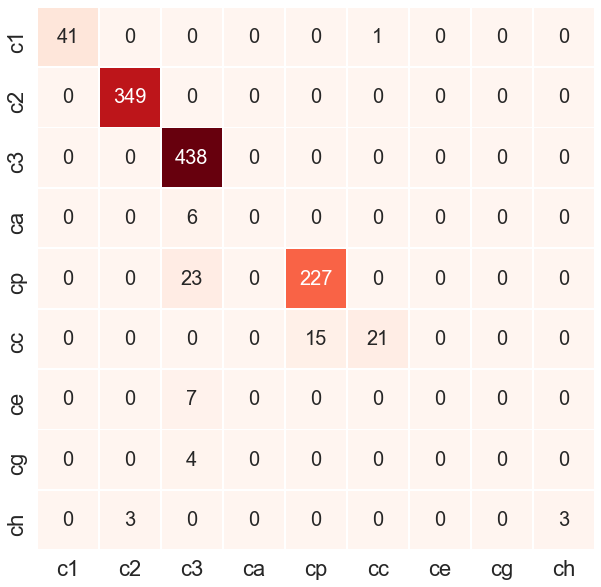

In [84]:
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm.iloc[1:10, 1:10], linewidths=.8, cbar=False, annot=True, fmt="d", cmap='Reds', annot_kws={'size':20})

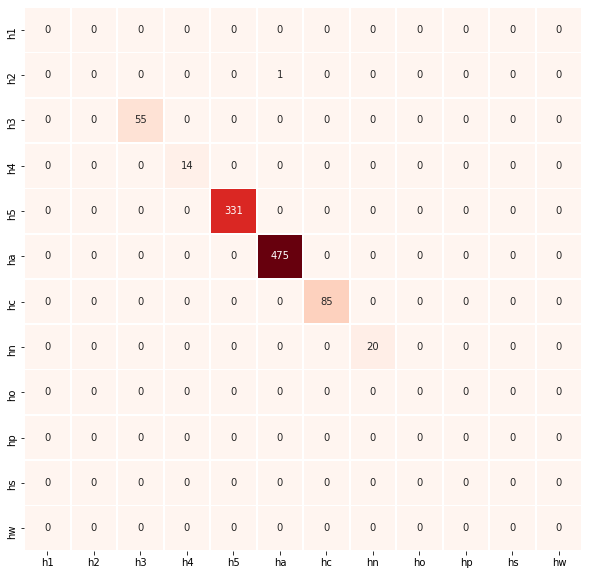

In [69]:
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm.iloc[15:27, 15:27], linewidths=.8, cbar=False, annot=True, fmt="d", cmap='Reds')

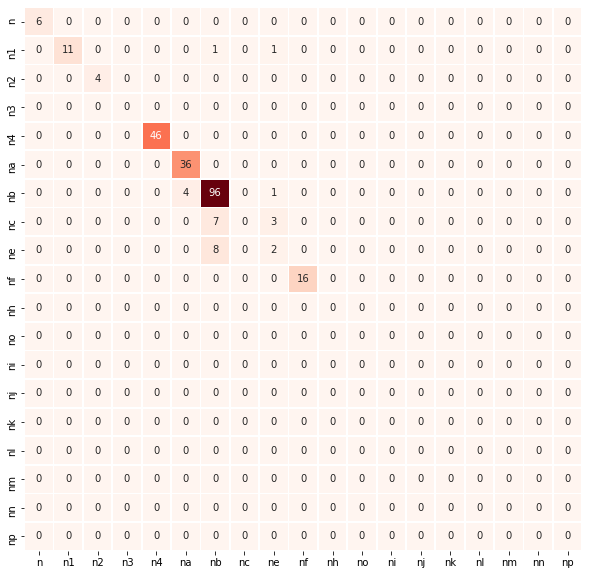

In [70]:
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm.iloc[32:51, 32:51], linewidths=.8, cbar=False, annot=True, fmt="d", cmap='Reds')

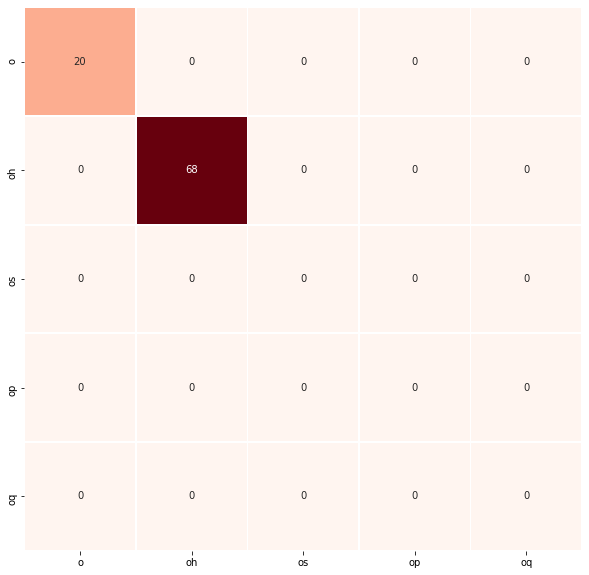

In [71]:
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm.iloc[52:57, 52:57], linewidths=.8, cbar=False, annot=True, fmt="d", cmap='Reds')

plt.figure(figsize=(10, 10))
sn.heatmap(df_cm.iloc[32:51, 32:51], linewidths=.8, cbar=False, annot=True, fmt="d", cmap='Reds')